In [31]:
from dotenv import load_dotenv
import sys

sys.path.append("../common")
load_dotenv()

True

In [32]:
import os
from langsmith_tracker import set_tracking
from langchain_print import stream_response
from multimodal import MultiModal
from tools_news import GoogleNews

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="15.Agent, AgentExcutor")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 15.Agent, AgentExcutor]


### 도구 호출 에이전트(Tool Calling Agent)

`Tool Calling Agent`는 도구를 바인딩 하고 알아서 판단하여 도구를 사용할 수 있게 합니다.  
`Agent`는 사이클의 개념도 포함합니다. 아래는 도식화한 그림입니다.  
즉, **Tool Calling Agent는 LLM 에 도구를 바인딩하고 Agent 사이클이 추가된 개념**이라고 할 수 있습니다.  
Tool Calling Agent를 Langchain 에서는 여러 모델을 통합시켜두었습니다. OpenAI, Anthropic, Google Gemini, Mistral, Ollama 과 같은 공급자 구현을 지원합니다.  

![toos_binding_agent.png](./images/toos_binding_agent.png)

In [7]:
from langchain.tools import tool
from typing import List, Dict, Annotated
from tools_news import GoogleNews
from langchain_experimental.utilities import PythonREPL


# 구글 뉴스 검색 도구 생성
@tool
def search_news(query: str) -> List[Dict[str, str]]:
    """Search Google News by input keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


# 코드 생성 도구 생성
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to excute to generate your chart."]
):
    """Use this to excute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user."""
    result = ""
    try:
        result = PythonREPL().run(code)
    except BaseException as e:
        print(f"Failed to excute. Error: {repr(e)}")
    finally:
        return result


print(f"도구 이름: {search_news.name}")
print(f"도구 설명: {search_news.description}")
print(f"도구 이름: {python_repl_tool.name}")
print(f"도구 설명: {python_repl_tool.description}")

도구 이름: search_news
도구 설명: Search Google News by input keyword
도구 이름: python_repl_tool
도구 설명: Use this to excute python code. If you want to see the output of a value, you should print it out with `print(...)`. This is visible to the user.


In [9]:
# tools 정의
tools = [search_news, python_repl_tool]

### Agent Prompt 생성
- `chat_history`: 이전 대화 내용을 저장하는 변수(멀티턴을 지원하지 않는다면, 생략 가능합니다.)
- `agent_scratchpad`: 에이전트가 임시로 저장하는 변수
- `input`: 사용자 입력

In [14]:
from langchain_core.prompts import ChatPromptTemplate

# 프롬프트 생성
# 프롬프트는 에이전트에게 모델이 수행할 작업을 설명하는 텍스트를 제공, 도구의 이름과 역할 전달
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are helpful assistant. Make sure to use the `search_news` tool for searching keyword related news.",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

### Agent 생성

In [16]:
from langchain_openai import ChatOpenAI
from langchain.agents import create_tool_calling_agent

# 모델 정의
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# Agent 설정
agent = create_tool_calling_agent(llm, tools, prompt)

### AgentExcutor

AgentExcutor 는 도구를 사용하는 에이전트를 실행하는 클래스입니다. 실행함에 있어서 Agent Cycle을 제어하기 위한 클래스 입니다.  
  

**주요 속성**
- `agent`: 실행 루프의 각 단계에서 계획을 생성하고 행동을 결정하는 에이전트
- `tools`: 에이전트가 사용할 수 있는 유효한 도구 목록
- `return_intermediate_steps`: 최종 출력과 함께 에이전트의 중간 단계 경로를 반환할지 여부
- `max_iterations`: 실행 루프를 종료하기 전 최대 단계 수
- `max_execution_time`: 실행 루프에 소요될 수 있는 최대 시간
- `early_stopping_method`: 에이전트가 `AgentFinish를` 반환하지 않을 때 사용할 조기 종료 방법. ("force" or "generate")
  - `"force"` 는 시간 또는 반복 제한에 도달하여 중지되었다는 문자열을 반환합니다.
  - `"generate"` 는 에이전트의 LLM 체인을 마지막으로 한 번 호출하여 이전 단계에 따라 최종 답변을 생성합니다.
- `handle_parsing_errors`: 에이전트의 출력 파서에서 발생한 오류 처리 방법. (True, False, 또는 오류 처리 함수)
- `trim_intermediate_steps`: 중간 단계를 트리밍하는 방법. (-1 trim 하지 않음, 또는 트리밍 함수)

**주요 메서드**
- `invoke`: 에이전트 실행
- `stream`: 최종 출력에 도달하는 데 필요한 단계를 스트리밍

**주요 기능**
- 도구 검증: 에이전트와 호환되는 도구인지 확인
- 실행 제어: 최대 반복 횟수 및 실행 시간 제한 설정 가능
- 오류 처리: 출력 파싱 오류에 대한 다양한 처리 옵션 제공
- 중간 단계 관리: 중간 단계 트리밍 및 반환 옵션
- 비동기 지원: 비동기 실행 및 스트리밍 지원

**최적화 팁**
- max_iterations와 max_execution_time을 적절히 설정하여 실행 시간 관리
- trim_intermediate_steps를 활용하여 메모리 사용량 최적화
- 복잡한 작업의 경우 stream 메서드를 사용하여 단계별 결과 모니터링

In [24]:
from langchain.agents import AgentExecutor

#  AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    max_iterations=10,
    max_execution_time=10,
    handle_parsing_errors=True,  # 웬만하면 True
)

# AgentExecutor 실행
result = agent_executor.invoke(
    {
        "input": "비트코인 투자와 관련된 뉴스를 검색해 주세요."
    }  # 구어체로 input을 주어도 아래 query 를 확인하면 정확한 키워드를 찾아서 검색을 시도
)

print("Agent 실행 결과:")
print(result["output"])



> Entering new AgentExecutor chain...

Invoking: `search_news` with `{'query': '비트코인 투자'}`


[{'url': 'https://news.google.com/rss/articles/CBMic0FVX3lxTE5EYWRObmltSllQbTVCZnBCTDl4dS1hQUlGaEMtQWJ2Q2VfSy13S3FTTVpMQ2t6Tm1WeGVoNjRwM0owcUk2dzlhMWt3WGgxRlhpWUxGNHE3ODdzLVRQclRtYzBDang2WkQ4OXVWeHVXazY5SVU?oc=5', 'content': '우리도 마이크로스트래티지처럼…현금부자 美 기업, 암호화폐 투자 러시 - 디지털투데이'}, {'url': 'https://news.google.com/rss/articles/CBMifkFVX3lxTE5JanUtanRwV0NJQXUzUWR4Qm10SVlQbzh5RGZEZmlzM3NhWExXWDBhUHpDWjY3NUJWMFVFQmtPWWRXMnkwdW9ndmotcUtzSUtrUzktR1JLSDItNFZTRFc1ZnkyeW10TDdJRGUwOXNXbUYxV0t6SW1lUk1oZHFuZw?oc=5', 'content': '코인으로 벼락부자?…투자 고민된다면[왓츠 유어 ETF] - 이데일리'}, {'url': 'https://news.google.com/rss/articles/CBMib0FVX3lxTFBqaVhiN05tUU1EdFB6ci1mNXoyY1NOVk9NX3VURlFkSzhVblNIS2w3TTJ6enZmUi1NNV9ZVXhTZnVKUTljVW9tZnNBd3F1Unk0b3dIQV9hWm1TOWZpS1BNVGJsTF9SMS1ySVpxT2ZTbw?oc=5', 'content': '[재테크+] 10년 전 1억 투자했더라면…코인·금·삼전 비교해보니 - 서울신문'}, {'url': 'https://news.google.com/rss/articles/CBMiVEFVX3lxTE11VjVIY21jNW5wS3MtTjV

### Stream 출력으로 단계별 결과 확인
AgentExecutor의 `stream()` 메소드를 사용하여 에이전트의 중간 단계를 스트리밍할 것입니다.  
  
`stream()`의 출력은 (Action, Observation) 쌍 사이에서 번갈아 나타나며, 최종적으로 에이전트가 목표를 달성했다면 답변으로 마무리됩니다.  
  
다음과 같은 형태로 보일 것입니다.  
1. Action 출력
2. Observation 출력
3. Action 출력
4. Observation 출력

... (목표 달성까지 계속) ...  
  
그 다음, 최종 목표가 달성되면 에이전트는 최종 답변을 출력할 것입니다.  
  
이러한 출력의 내용은 다음과 같이 요약됩니다.  

<table>
  <tr>
    <th>출력</th>
    <th>내용</th>
  </tr>
  <tr>
    <td>Action</td>
    <td>
      <b>actions</b>: AgentAction 또는 그 하위 클래스, 도구를 선택하는 과정<br />
      <b>messages</b>: 액션 호출에 해당하는 채팅 메시지
    </td>
  </tr>
  <tr>
    <td>Observation</td>
    <td>
      <b>steps</b>: 현재 액션과 그 관찰을 포함한 에이전트가 지금까지 수행한 작업의 기록<br/>
      <b>messages</b>: 함수 호출 결과(즉, 관찰)를 포함한 채팅 메시지
    </td>
  </tr>
  <tr>
    <td>Final Answer</td>
    <td>
      <b>output</b>: AgentFinish<br/>
      <b>messages</b>: 최종 출력을 포함한 채팅 메시지
    </td>
  </tr>
</table>

In [33]:
from langchain.agents import AgentExecutor

# AgentExecutor 생성
agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=False,
    handle_parsing_errors=True,
)

In [25]:
# 스트리밍 모드로 실행합니다
result = agent_executor.stream(
    {"input": "비트코인 투자와 관련된 뉴스를 검색해 주세요."}
)

for step in result:
    # 중간 단계 출력
    print(step)
    print("===" * 20)



> Entering new None chain...
{'actions': [ToolAgentAction(tool='search_news', tool_input={'query': '비트코인 투자'}, log="\nInvoking: `search_news` with `{'query': '비트코인 투자'}`\n\n\n", message_log=[AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_JpbSGsEDBHiQmAXd0WQI23uX', 'function': {'arguments': '{"query":"비트코인 투자"}', 'name': 'search_news'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_3de1288069'}, id='run-7d126e40-1552-4fb7-973d-c8a13f510137', tool_calls=[{'name': 'search_news', 'args': {'query': '비트코인 투자'}, 'id': 'call_JpbSGsEDBHiQmAXd0WQI23uX', 'type': 'tool_call'}], tool_call_chunks=[{'name': 'search_news', 'args': '{"query":"비트코인 투자"}', 'id': 'call_JpbSGsEDBHiQmAXd0WQI23uX', 'index': 0, 'type': 'tool_call_chunk'}])], tool_call_id='call_JpbSGsEDBHiQmAXd0WQI23uX')], 'messages': [AIMessageChunk(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id

#### 중간 단계 출력을 사용자 정의 함수로 출력

다음의 3개 함수를 정의하고 이를 통해 중간 단계 출력을 사용자 정의합니다.  
- tool_callback: 도구 호출 출력을 처리하는 함수
- observation_callback: 관찰(Observation) 출력을 처리하는 함수
- result_callback: 최종 답변 출력을 처리하는 함수

In [34]:
from langchain_print import AgentStreamParser

agent_stream_parser = AgentStreamParser()

스트리밍 방식으로 Agent의 응답 과정을 확인합니다.

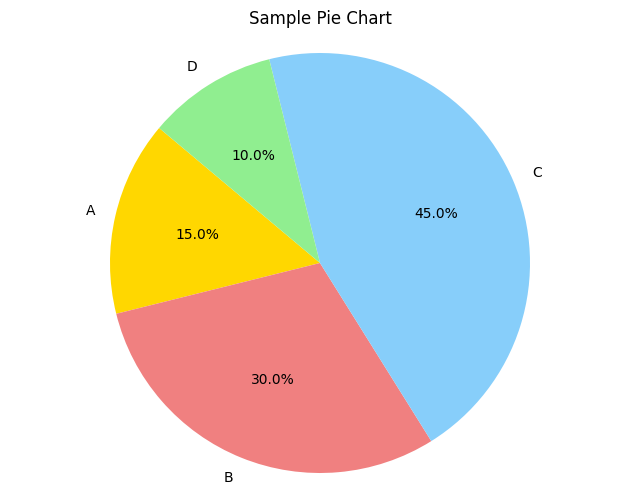

[도구 호출]
Tool: python_repl_tool
code: import matplotlib.pyplot as plt

# 데이터
sizes = [15, 30, 45, 10]
labels = ['A', 'B', 'C', 'D']
colors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']

# 파이 차트 그리기
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Sample Pie Chart')
plt.show()
Log: 
Invoking: `python_repl_tool` with `{'code': "import matplotlib.pyplot as plt\n\n# 데이터\nsizes = [15, 30, 45, 10]\nlabels = ['A', 'B', 'C', 'D']\ncolors = ['gold', 'lightcoral', 'lightskyblue', 'lightgreen']\n\n# 파이 차트 그리기\nplt.figure(figsize=(8, 6))\nplt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)\nplt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.\nplt.title('Sample Pie Chart')\nplt.show()"}`



[관찰 내용]
Observation: 
[최종 답변]
파이 차트가 성공적으로 그려졌습니다. 차트에는 A, B, C, D라는 레이블이 있으며, 각 섹션의 비율이 표시되어 있습니다. 차트

In [35]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream(
    {"input": "matplotlib 을 사용하여 pie 차트를 그리는 코드를 작성하고 실행하세요."}
)

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    # print(step)
    agent_stream_parser.process_agent_steps(step)

In [36]:
from langchain_print import AgentStreamParser, AgentCallbacks


# 도구 호출 시 실행되는 콜백 함수입니다.
def tool_callback(tool) -> None:
    print("<<<<<<< 도구 호출 >>>>>>")
    print(f"Tool: {tool.get('tool')}")  # 사용된 도구의 이름을 출력합니다.
    print("<<<<<<< 도구 호출 >>>>>>")


# 관찰 결과를 출력하는 콜백 함수입니다.
def observation_callback(observation) -> None:
    print("<<<<<<< 관찰 내용 >>>>>>")
    print(
        f"Observation: {observation.get('observation')[0]}"
    )  # 관찰 내용을 출력합니다.
    print("<<<<<<< 관찰 내용 >>>>>>")


# 최종 결과를 출력하는 콜백 함수입니다.
def result_callback(result: str) -> None:
    print("<<<<<<< 최종 답변 >>>>>>")
    print(result)  # 최종 답변을 출력합니다.
    print("<<<<<<< 최종 답변 >>>>>>")


# AgentCallbacks 객체를 생성하여 각 단계별 콜백 함수를 설정합니다.
agent_callbacks = AgentCallbacks(
    tool_callback=tool_callback,
    observation_callback=observation_callback,
    result_callback=result_callback,
)

# AgentStreamParser 객체를 생성하여 에이전트의 실행 과정을 파싱합니다.
agent_stream_parser = AgentStreamParser(agent_callbacks)

출력 값이 수정한 콜백 함수의 출력 값으로 변경된 것을 확인할 수 있습니다.

In [37]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
result = agent_executor.stream({"input": "비트코인 투자관련 뉴스를 검색해 주세요."})

for step in result:
    # 중간 단계를 parser 를 사용하여 단계별로 출력
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMic0FVX3lxTE5EYWRObmltSllQbTVCZnBCTDl4dS1hQUlGaEMtQWJ2Q2VfSy13S3FTTVpMQ2t6Tm1WeGVoNjRwM0owcUk2dzlhMWt3WGgxRlhpWUxGNHE3ODdzLVRQclRtYzBDang2WkQ4OXVWeHVXazY5SVU?oc=5', 'content': '우리도 마이크로스트래티지처럼…현금부자 美 기업, 암호화폐 투자 러시 - 디지털투데이'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
다음은 비트코인 투자와 관련된 최근 뉴스 기사들입니다:

1. [우리도 마이크로스트래티지처럼…현금부자 美 기업, 암호화폐 투자 러시 - 디지털투데이](https://news.google.com/rss/articles/CBMic0FVX3lxTE5EYWRObmltSllQbTVCZnBCTDl4dS1hQUlGaEMtQWJ2Q2VfSy13S3FTTVpMQ2t6Tm1WeGVoNjRwM0owcUk2dzlhMWt3WGgxRlhpWUxGNHE3ODdzLVRQclRtYzBDang2WkQ4OXVWeHVXazY5SVU?oc=5)

2. [코인으로 벼락부자?…투자 고민된다면[왓츠 유어 ETF] - 이데일리](https://news.google.com/rss/articles/CBMifkFVX3lxTE5JanUtanRwV0NJQXUzUWR4Qm10SVlQbzh5RGZEZmlzM3NhWExXWDBhUHpDWjY3NUJWMFVFQmtPWWRXMnkwdW9ndmotcUtzSUtrUzktR1JLSDItNFZTRFc1ZnkyeW10TDdJRGUwOXNXbUYxV0t6SW1lUk1oZHFuZw?oc=5)

3. [10년 전 1억 투자했더라면…코인·금·삼전 비교해보니 - 서울신문

### 이전 대화내용 기억하는 Agent, 멀티턴
이전의 대화내용을 기억하기 위해서는 `RunnableWithMessageHistory` 를 사용하여 `AgentExecutor` 를 감싸줍니다.  
  
`RunnableWithMessageHistory` 에 대한 자세한 내용은 아래 링크를 참고해 주세요.  
  
참고
- [RunnableWithMessageHistory](https://wikidocs.net/254682)

In [38]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

# session_id 를 저장할 딕셔너리 생성
store = {}


# session_id 를 기반으로 세션 기록을 가져오는 함수
def get_session_history(session_ids):
    if session_ids not in store:  # session_id 가 store에 없는 경우
        # 새로운 ChatMessageHistory 객체를 생성하여 store에 저장
        store[session_ids] = ChatMessageHistory()
    return store[session_ids]  # 해당 세션 ID에 대한 세션 기록 반환


# 채팅 메시지 기록이 추가된 에이전트를 생성합니다.
agent_with_chat_history = RunnableWithMessageHistory(
    agent_executor,
    # 대화 session_id
    get_session_history,
    # 프롬프트의 질문이 입력되는 key: "input"
    input_messages_key="input",
    # 프롬프트의 메시지가 입력되는 key: "chat_history"
    history_messages_key="chat_history",
)

In [39]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "안녕? 내 이름은 노바디야!"},
    # session_id 설정
    config={"configurable": {"session_id": "251202history"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
안녕하세요, 노바디님! 어떻게 도와드릴까요?
<<<<<<< 최종 답변 >>>>>>


In [40]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "내 이름이 뭐라고?"},
    # session_id 설정
    config={"configurable": {"session_id": "251202history"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
당신의 이름은 노바디입니다!
<<<<<<< 최종 답변 >>>>>>


In [41]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "내 이메일 주소는 nobody@agent.com 이야. 회사 이름은 라이징 투자 회사야."
    },
    # session_id 설정
    config={"configurable": {"session_id": "251202history"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
알겠습니다, 노바디님! 라이징 투자 회사와 관련하여 어떤 정보를 원하시나요? 또는 다른 도움이 필요하신가요?
<<<<<<< 최종 답변 >>>>>>


In [43]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {
        "input": "비트코인 투자에 관련한 최신 뉴스 5개를 검색해서 이메일의 본문으로 작성해줘. "
        "수신인에는 `워렛버핏 투자자님` 그리고, 발신인에는 내 인적정보를 적어줘."
        "급한 업무니 빠르게 답변부탁드린다고 전해주고, 정중한 어조로 작성하고, 메일의 시작과 끝에는 적절한 인사말과 맺음말을 적어줘."
    },
    # session_id 설정
    config={"configurable": {"session_id": "251202history"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 도구 호출 >>>>>>
Tool: search_news
<<<<<<< 도구 호출 >>>>>>
<<<<<<< 관찰 내용 >>>>>>
Observation: {'url': 'https://news.google.com/rss/articles/CBMic0FVX3lxTE5EYWRObmltSllQbTVCZnBCTDl4dS1hQUlGaEMtQWJ2Q2VfSy13S3FTTVpMQ2t6Tm1WeGVoNjRwM0owcUk2dzlhMWt3WGgxRlhpWUxGNHE3ODdzLVRQclRtYzBDang2WkQ4OXVWeHVXazY5SVU?oc=5', 'content': '우리도 마이크로스트래티지처럼…현금부자 美 기업, 암호화폐 투자 러시 - 디지털투데이'}
<<<<<<< 관찰 내용 >>>>>>
<<<<<<< 최종 답변 >>>>>>
아래는 워렛버핏 투자자님께 보낼 이메일 본문입니다.

---

제목: 비트코인 투자 관련 최신 뉴스 업데이트

워렛버핏 투자자님,

안녕하세요. 라이징 투자 회사의 노바디입니다. 급한 업무로 인해 비트코인 투자와 관련된 최신 뉴스를 정리하여 전달드립니다. 아래는 최근의 주요 뉴스 5개입니다.

1. [우리도 마이크로스트래티지처럼…현금부자 美 기업, 암호화폐 투자 러시 - 디지털투데이](https://news.google.com/rss/articles/CBMic0FVX3lxTE5EYWRObmltSllQbTVCZnBCTDl4dS1hQUlGaEMtQWJ2Q2VfSy13S3FTTVpMQ2t6Tm1WeGVoNjRwM0owcUk2dzlhMWt3WGgxRlhpWUxGNHE3ODdzLVRQclRtYzBDang2WkQ4OXVWeHVXazY5SVU?oc=5)

2. [코인으로 벼락부자?…투자 고민된다면[왓츠 유어 ETF] - 이데일리](https://news.google.com/rss/articles/CBMifkFVX3lxTE5JanUtanRwV0NJQXUzUWR4Qm10SVlQbzh5RGZEZmlzM3NhWExXWDBhUHpDWjY3NUJWMFVFQmtPW

세션 아이디가 바뀌면 기억하지 못합니다. 아래 예시입니다.

In [44]:
# 질의에 대한 답변을 스트리밍으로 출력 요청
response = agent_with_chat_history.stream(
    {"input": "내 이름이 뭐야?"},
    # session_id 설정
    config={"configurable": {"session_id": "def456"}},
)

# 출력 확인
for step in response:
    agent_stream_parser.process_agent_steps(step)

<<<<<<< 최종 답변 >>>>>>
죄송하지만, 당신의 이름을 알 수 있는 정보가 없습니다. 당신의 이름을 알려주시면 좋겠습니다!
<<<<<<< 최종 답변 >>>>>>
